# ランダムに作成した100個の音を聞き分けられるかチャレンジ

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tcn

%matplotlib inline

In [2]:
import import_ipynb
import functions as myfunc

importing Jupyter notebook from functions.ipynb


## 学習済みモデルのロード

In [3]:
model = tf.keras.models.load_model("./model/tcn_snare")  # SavedModel形式
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                393408    
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 393,538
Trainable params: 393,538
Non-trainable params: 0
_________________________________________________________________


## チャレンジ用音声ファイルの読み込み

In [4]:
def load_audio_as_ds(filename, batch_size=64):
    clips = myfunc.load_audio_clips(filename, squeeze=False)
    ds = tf.data.Dataset.from_tensor_slices(clips)
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x: (x, None))  # 正解ラベルは未設定
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [5]:
ds = load_audio_as_ds("./data/challenge.flac")

./data/challenge.flac 48.0kHz, clips:100, duration:24000, normalize:True


## 推論

In [6]:
predicts = model.predict(ds)

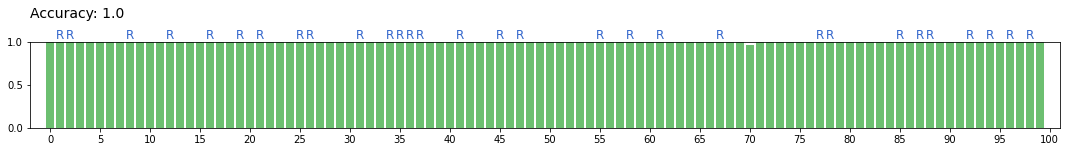

In [7]:
def show_result(predicts, true_labels: np.ndarray):
    predicts = tf.nn.softmax(predicts)  # ロジット値を確率に変換（0..1）
    pred_labels = myfunc.list_map(lambda x: np.argmax(x), predicts)  # 予測ラベル
    pred_percents = myfunc.list_map(lambda x: np.max(x), predicts)  # 予想ラベルの確率
    is_corrects = true_labels == pred_labels  # 正解かどうか

    # グラフ表示
    colors = myfunc.list_map(lambda x: "#6CBF70" if x else "#E65A29", is_corrects)
    title = f"Accuracy: {np.count_nonzero(is_corrects) / np.size(is_corrects)}"

    fig = plt.figure(figsize=(14.7, 2), constrained_layout=True)
    ax = fig.subplots(1, 1)
    ax.set_title(title, loc="left", fontsize=14, pad=24)
    ax.bar(height=pred_percents, x=range(len(pred_labels)), color=colors)
    ax.set_xlim(-2, len(pred_labels) + 1)  # グラフのスペース調整
    ax.set_xticks(np.arange(0, 101, 5))
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0.0, 0.5, 1.0])

    # 正解ラベルを表示（右スティック側だけ、上部にRを表示。それ以外は左スティック）
    true_labels_dec = myfunc.list_map(lambda x: "R" if x else "", true_labels)
    for x, l in zip(range(100), true_labels_dec):
        ax.text(x, 1, l, ha="center", va="bottom", fontsize=12, color="#36C")

    plt.show()


# 正解ラベルを読み込み
true_labels_str = myfunc.readlines_as_list("./data/challenge_true_labels.txt")
true_labels = myfunc.string_to_list(true_labels_str[0])


# 結果表示
show_result(predicts, true_labels)

## 人間（私）の予測結果

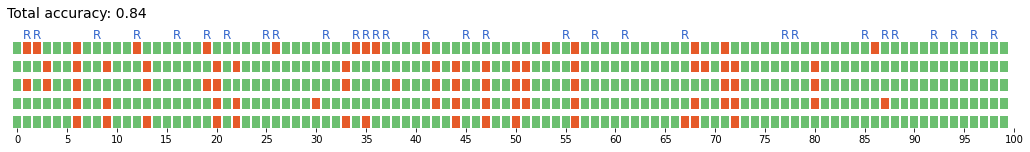

In [8]:
# 人間の予測結果
my_preds = myfunc.readlines_as_list("./data/challenge_my_prediction.txt")

# 正解ラベルとの突き合わせ
results = myfunc.list_map(lambda x: true_labels == myfunc.string_to_list(x), my_preds)
title = f"Total accuracy: {np.count_nonzero(results) / np.size(results)}"  # 正解数/全体数

# グラフで結果を表示
fig = plt.figure(figsize=(14.2, 2), constrained_layout=True)
ax = fig.subplots(len(results), 1)
for i, result in enumerate(results):
    colors = myfunc.list_map(lambda x: "#6CBF70" if x else "#E65A29", result)
    ax[i].set_frame_on(False)
    ax[i].set_xlim(-1, len(result))  # グラフのスペース調整
    ax[i].bar(height=1, x=range(len(result)), color=colors)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# 正解ラベルを表示（右スティック側だけ、上部にRを表示。それ以外は左スティック）
true_labels_dec = myfunc.list_map(lambda x: "R" if x else "", true_labels)
for x, l in zip(range(100), true_labels_dec):
    ax[0].text(x, 1.1, l, ha="center", va="bottom", fontsize=12, color="#36C")

ax[0].set_title(title, loc="left", fontsize=14, pad=24)
ax[-1].set_xticks(np.arange(0, 101, 5))  # 最後にx軸のラベルを表示
plt.show()